In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import pandas as pd
from os import listdir
from os.path import isfile, join, exists
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns
from misc_functions import player_dist
from misc_functions import add_names
from misc_functions import fix_shot_times_edited
from misc_functions import fix_shot_locations

In [133]:
##The affect of fixing over all the games:
shots_fixed=pd.read_csv("data/shots/shots_fixed.csv")
shots_fixed.sort_values('GAME_EVENT_ID',axis=0, ascending=True, inplace=True)
shots_fixed.reset_index(inplace=True,drop=True)
shots_fixed.insert(27,'CLOSEST_DEFENDER',0)##Insert column for stat of interest


game1=pd.read_csv('data/converted/0021500438_converted.csv')##Read in the tracking data
shots_fixed1 = shots_fixed.loc[shots_fixed.GAME_ID==21500438].reset_index(drop=True)
game2=pd.read_csv('data/converted/0021500502_converted.csv')##Read in the tracking data
shots_fixed2 = shots_fixed.loc[shots_fixed.GAME_ID==21500502].reset_index(drop=True)
game3=pd.read_csv('data/converted/0021500507_converted.csv')##Read in the tracking data
shots_fixed3 = shots_fixed.loc[shots_fixed.GAME_ID==21500507].reset_index(drop=True)

fix_shot_times_edited(shots_fixed1,game1)
fix_shot_locations(shots_fixed1,game1)

fix_shot_times_edited(shots_fixed2,game2)
fix_shot_locations(shots_fixed2,game2)

fix_shot_times_edited(shots_fixed3,game3)
fix_shot_locations(shots_fixed3,game3)

In [134]:
add_names(game1)
add_names(game2)
add_names(game3)

In [135]:
game2.head()

,team_id,player_id,x_loc,y_loc,radius,game_clock,shot_clock,quarter,game_id,event_id,x_loc_original,y_loc_original,player_name,player_jersey
0,-1,-1,158.3611,356.1269,4.75877,673.77,22.17,1,21500502,1,40.36269,9.16389,ball,NaN
1,1610612759,1495,-4.7863,199.9626,0.00000,673.77,22.17,1,21500502,1,69.25374,24.52137,Tim Duncan,21
2,1610612759,2225,-98.6392,323.3324,0.00000,673.77,22.17,1,21500502,1,56.91676,15.13608,Tony Parker,9
3,1610612759,200746,35.6538,323.7781,0.00000,673.77,22.17,1,21500502,1,56.87219,28.56538,LaMarcus Aldridge,12
4,1610612759,201980,-145.2508,258.5379,0.00000,673.77,22.17,1,21500502,1,63.39621,10.47492,Danny Green,14


In [136]:
def add_closest_def_and_dist(shots_fixed,game):
    for i in range(0,len(shots_fixed)):
        game_shot=game.loc[game['event_id']==shots_fixed.iloc[i].GAME_EVENT_ID]
        game_shot=game_shot.loc[game_shot['game_clock']==shots_fixed.iloc[i].SHOT_TIME]
        shooter_loc = game_shot[game_shot.player_name==shots_fixed.iloc[i].PLAYER_NAME][["x_loc", "y_loc"]]
        group = game_shot[(game_shot.player_name!=shots_fixed.iloc[i].PLAYER_NAME) & (game_shot.team_id!=shots_fixed.iloc[i].TEAM_ID)].groupby("player_name")[["x_loc", "y_loc"]]
        shooter_dist = group.apply(player_dist, player_b=(shooter_loc))

        closest_defender=shooter_dist.min()
        shots_fixed.loc[i,('CLOSEST_DEFENDER')]=closest_defender[0]

    ##Use the euclidean function to find distance between shot location and hoop:(0,0)
    shots_fixed['TRUE_SHOT_DIST']=shots_fixed.apply(lambda row: euclidean((row['LOC_X'], row['LOC_Y']), (0, 0)), axis=1)

In [137]:
add_closest_def_and_dist(shots_fixed1,game1)
add_closest_def_and_dist(shots_fixed2,game2)
add_closest_def_and_dist(shots_fixed3,game3)

In [138]:
def next_poss_info(shots_fixed):
    GAME_ID=shots_fixed.at[0,'GAME_ID']
    home=pd.read_json(f'data/00{GAME_ID}.json')['events'][0]['home']
    visitor=pd.read_json(f'data/00{GAME_ID}.json')['events'][0]['visitor']
    ##Split the dataframe so it is easier to find a team's next shot
    shots_fixed_visitor=shots_fixed.loc[shots_fixed['TEAM_ID']==visitor['teamid']].reset_index(drop=True)
    shots_fixed_home=shots_fixed.loc[shots_fixed['TEAM_ID']==home['teamid']].reset_index(drop=True)


    shots_fixed_home.loc[:, 'CLOSEST_DEFENDER_NEXT'] = shots_fixed_home['CLOSEST_DEFENDER'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_home.loc[len(shots_fixed_home) - 1, 'CLOSEST_DEFENDER_NEXT'] = np.nan

    shots_fixed_home.loc[:, 'SHOT_DISTANCE_NEXT'] = shots_fixed_home['TRUE_SHOT_DIST'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_home.loc[len(shots_fixed_home) - 1, 'SHOT_DISTANCE_NEXT'] = np.nan

    shots_fixed_home.loc[:, 'EVENT_TYPE_NEXT'] = shots_fixed_home['EVENT_TYPE'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_home.loc[len(shots_fixed_home) - 1, 'EVENT_TYPE_NEXT'] = np.nan

    shots_fixed_home.loc[:, 'SHOT_ZONE_RANGE_NEXT'] = shots_fixed_home['SHOT_ZONE_RANGE'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_home.loc[len(shots_fixed_home) - 1, 'SHOT_ZONE_RANGE_NEXT'] = np.nan

    shots_fixed_visitor.loc[:, 'CLOSEST_DEFENDER_NEXT'] = shots_fixed_visitor['CLOSEST_DEFENDER'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_visitor.loc[len(shots_fixed_visitor) - 1, 'CLOSEST_DEFENDER_NEXT'] = np.nan

    shots_fixed_visitor.loc[:, 'SHOT_DISTANCE_NEXT'] = shots_fixed_visitor['TRUE_SHOT_DIST'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_visitor.loc[len(shots_fixed_visitor) - 1, 'SHOT_DISTANCE_NEXT'] = np.nan

    shots_fixed_visitor.loc[:, 'EVENT_TYPE_NEXT'] = shots_fixed_visitor['EVENT_TYPE'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_visitor.loc[len(shots_fixed_visitor) - 1, 'EVENT_TYPE_NEXT'] = np.nan

    shots_fixed_visitor.loc[:, 'SHOT_ZONE_RANGE_NEXT'] = shots_fixed_visitor['SHOT_ZONE_RANGE'].shift(-1)
    # The last row will not have a next shot, so we fill it with NaN
    shots_fixed_visitor.loc[len(shots_fixed_visitor) - 1, 'SHOT_ZONE_RANGE_NEXT'] = np.nan

    ##Add the two data frames back together
    all_shots = [shots_fixed_home,shots_fixed_visitor]
    shots_fixed = pd.concat(all_shots)
    ##Put the shots in the order they occured again
    shots_fixed.sort_values('GAME_EVENT_ID',axis=0, ascending=True, inplace=True)
    shots_fixed.reset_index(inplace=True,drop=True)
    return shots_fixed

In [139]:
shots_fixed1=next_poss_info(shots_fixed1)
shots_fixed2=next_poss_info(shots_fixed2)
shots_fixed3=next_poss_info(shots_fixed3)

In [140]:
##Concatenate all games together to form bigger data set
shots_fixed = pd.concat([shots_fixed1,shots_fixed2,shots_fixed3])

In [141]:
##Sort by game
shots_fixed.sort_values('GAME_ID',axis=0, ascending=True, inplace=True)
shots_fixed.reset_index(inplace=True,drop=True)
shots_fixed

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,VTM,EVENTTIME,QUARTER,SHOT_TIME,CLOSEST_DEFENDER,TRUE_SHOT_DIST,CLOSEST_DEFENDER_NEXT,SHOT_DISTANCE_NEXT,EVENT_TYPE_NEXT,SHOT_ZONE_RANGE_NEXT
0,Shot Chart Detail,21500438,4,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,3,...,CLE,663,1.0,662.99,57.782882,210.413840,65.481301,53.932867,Missed Shot,24+ ft.
1,Shot Chart Detail,21500438,345,202684,Tristan Thompson,1610612739,Cleveland Cavaliers,3,4,36,...,CLE,276,3.0,276.01,160.594540,233.713812,76.783902,48.337849,Missed Shot,Less Than 8 ft.
2,Shot Chart Detail,21500438,347,202691,Klay Thompson,1610612744,Golden State Warriors,3,4,27,...,CLE,267,3.0,267.00,93.633269,289.188880,149.025775,203.280481,Missed Shot,Less Than 8 ft.
3,Shot Chart Detail,21500438,349,202684,Tristan Thompson,1610612739,Cleveland Cavaliers,3,4,11,...,CLE,251,3.0,251.02,76.783902,48.337849,55.406769,258.291168,Missed Shot,Less Than 8 ft.
4,Shot Chart Detail,21500438,351,203110,Draymond Green,1610612744,Golden State Warriors,3,4,3,...,CLE,243,3.0,243.01,149.025775,203.280481,33.827325,10.841496,Made Shot,Less Than 8 ft.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,Shot Chart Detail,21500507,151,202335,Patrick Patterson,1610612761,Toronto Raptors,2,6,42,...,CHI,402,2.0,402.02,95.822176,76.154876,103.283390,393.985478,Made Shot,Less Than 8 ft.
477,Shot Chart Detail,21500507,153,201959,Taj Gibson,1610612741,Chicago Bulls,2,6,20,...,CHI,380,2.0,380.02,216.705122,411.169143,42.702693,210.132504,Missed Shot,24+ ft.
478,Shot Chart Detail,21500507,154,202709,Cory Joseph,1610612761,Toronto Raptors,2,6,1,...,CHI,361,2.0,361.02,103.283390,393.985478,0.000000,306.031927,Missed Shot,Less Than 8 ft.
479,Shot Chart Detail,21500507,131,200768,Kyle Lowry,1610612761,Toronto Raptors,2,8,28,...,CHI,508,2.0,508.02,39.114928,50.047379,62.510051,298.702921,Missed Shot,16-24 ft.


In [142]:
stats_oi=shots_fixed[['EVENT_TYPE','EVENT_TYPE_NEXT','ACTION_TYPE','SHOT_TYPE','SHOT_ZONE_BASIC',
            'SHOT_ZONE_AREA','SHOT_ZONE_RANGE','CLOSEST_DEFENDER',
             'CLOSEST_DEFENDER_NEXT','TRUE_SHOT_DIST','SHOT_DISTANCE_NEXT','LOC_X','LOC_Y']].dropna()##DATA OF POTENTIAL INTEREST
stats_oi.reset_index(inplace=True,drop=True)
stats_oi

,EVENT_TYPE,EVENT_TYPE_NEXT,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_NEXT,TRUE_SHOT_DIST,SHOT_DISTANCE_NEXT,LOC_X,LOC_Y
0,Missed Shot,Missed Shot,Turnaround Bank shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,57.782882,65.481301,210.413840,53.932867,-144.7822,152.6830
1,Made Shot,Missed Shot,Putback Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,160.594540,76.783902,233.713812,48.337849,-200.7754,119.6302
2,Missed Shot,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,93.633269,149.025775,289.188880,203.280481,-89.7881,274.8969
3,Missed Shot,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,76.783902,55.406769,48.337849,258.291168,41.9448,24.0246
4,Missed Shot,Made Shot,Running Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,149.025775,33.827325,203.280481,10.841496,113.9157,168.3632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Missed Shot,Made Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,54.797230,216.705122,143.806193,411.169143,135.2262,48.9295
255,Missed Shot,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,95.822176,103.283390,76.154876,393.985478,-42.1650,63.4167
256,Made Shot,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,216.705122,42.702693,411.169143,210.132504,-146.6261,384.1365
257,Made Shot,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,103.283390,0.000000,393.985478,306.031927,64.7809,388.6232


Correlation Coefficient between TRUE_SHOT_DIST and CLOSEST_DEFENDER_NEXT: 0.004581397099727411


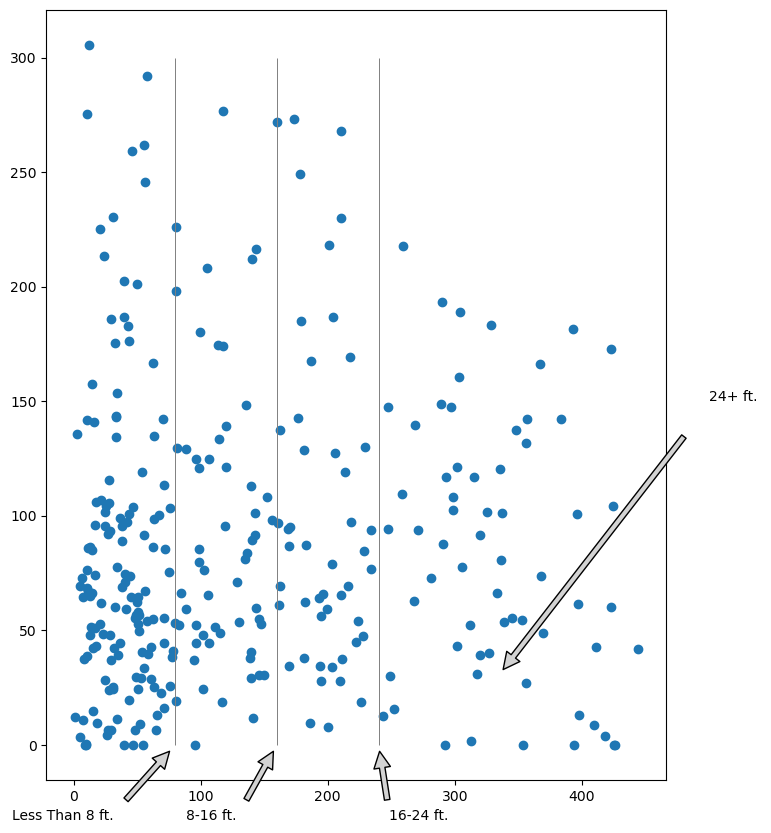

In [194]:
correlation_coefficient = stats_oi['TRUE_SHOT_DIST'].corr(stats_oi['CLOSEST_DEFENDER_NEXT'])

print(f"Correlation Coefficient between TRUE_SHOT_DIST and CLOSEST_DEFENDER_NEXT: {correlation_coefficient}")
plt.figure(figsize=(8,10))
x=shots_fixed.TRUE_SHOT_DIST
y=shots_fixed.CLOSEST_DEFENDER_NEXT

plt.scatter(x,y)##looking at this does not make me optimistic
plt.vlines(80, 0, 300, color='gray', lw=0.7)##Line at 8 ft.
plt.vlines(160, 0, 300, color='gray', lw=0.7)## " 16
plt.vlines(240, 0, 300, color='gray', lw=0.7)## " 24
plt.annotate("Less Than 8 ft. ", (80, 0), 
             xytext=(-48.725, -32.8), fontsize=10, 
             arrowprops=dict(facecolor='lightgray', shrink=0.10))
plt.annotate("8-16 ft. ", (160, 0), 
             xytext=(88.725, -32.8), fontsize=10, 
             arrowprops=dict(facecolor='lightgray', shrink=0.10))
plt.annotate("16-24 ft. ", (240, 0), 
             xytext=(247.9, -32.8), fontsize=10, 
             arrowprops=dict(facecolor='lightgray', shrink=0.10))
plt.annotate("24+ ft. ", (320, 20), 
             xytext=(500, 150), fontsize=10, 
             arrowprops=dict(facecolor='lightgray', shrink=0.10))
plt.show()

In [144]:
##Let's do the same thing but for each shot type to see if isolating for range betters correlation
stats_oi1=stats_oi.loc[stats_oi.SHOT_ZONE_RANGE == "Less Than 8 ft."]

correlation_coefficient = stats_oi1['TRUE_SHOT_DIST'].corr(stats_oi1['CLOSEST_DEFENDER_NEXT'])

print(f"Correlation Coefficient for Less Than 8 ft.: {correlation_coefficient}")


stats_oi2=stats_oi.loc[stats_oi.SHOT_ZONE_RANGE == "24+ ft."]

correlation_coefficient = stats_oi2['TRUE_SHOT_DIST'].corr(stats_oi2['CLOSEST_DEFENDER_NEXT'])

print(f"Correlation Coefficient for 24+ ft.: {correlation_coefficient}")


stats_oi3=stats_oi.loc[stats_oi.SHOT_ZONE_RANGE == "8-16 ft."]

correlation_coefficient = stats_oi3['TRUE_SHOT_DIST'].corr(stats_oi3['CLOSEST_DEFENDER_NEXT'])

print(f"Correlation Coefficient for 8-16 ft.: {correlation_coefficient}")


stats_oi4=stats_oi.loc[stats_oi.SHOT_ZONE_RANGE == "16-24 ft."]

correlation_coefficient = stats_oi4['TRUE_SHOT_DIST'].corr(stats_oi4['CLOSEST_DEFENDER_NEXT'])

print(f"Correlation Coefficient for 16-24 ft.: {correlation_coefficient}")

Correlation Coefficient for Less Than 8 ft.: -0.032485421102652894
Correlation Coefficient for 24+ ft.: 0.08100850663096516
Correlation Coefficient for 8-16 ft.: -0.06821817505625599
Correlation Coefficient for 16-24 ft.: 0.13856912462858748


In [145]:
##Let's compute some more elementary descriptive statistics

##closest defender after a short midrange attempt
MidrangeS=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "8-16 ft.")]
midS_mean=MidrangeS.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender after a short mid-range attempt was: {midS_mean}")
##closest defender after a long midrange attempt
MidrangeL=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "16-24 ft.")]
midL_mean=MidrangeL.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender after a long mid-range attempt was: {midL_mean}")
##closest defender after a short attempt
short=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "Less Than 8 ft.")]
short_mean=short.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender after a short attempt was: {short_mean}")
##closest defender after a 3-point attempt
three=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "24+ ft.")]
three_mean=three.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender after a 3-point attempt was: {three_mean}")

Mean distance of closest defender after a short mid-range attempt was: 90.00489608705152
Mean distance of closest defender after a long mid-range attempt was: 103.38452425821443
Mean distance of closest defender after a short attempt was: 80.63063333317666
Mean distance of closest defender after a 3-point attempt was: 89.24190218636129


In [146]:
##FG% after a short midrange attempt
MidrangeS1=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "8-16 ft.")]
midS_fg=len(MidrangeS1.loc[MidrangeS1.EVENT_TYPE_NEXT=="Made Shot"])
midS_fga=len(MidrangeS1.EVENT_TYPE_NEXT)
print(f"FG% after a short mid-range attempt was: {midS_fg/midS_fga}")
##FG% after a long midrange attempt
MidrangeL1=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "16-24 ft.")]
midL_fg=len(MidrangeL1.loc[MidrangeL1.EVENT_TYPE_NEXT=="Made Shot"])
midL_fga=len(MidrangeL1.EVENT_TYPE_NEXT)
print(f"FG% after a long mid-range attempt was: {midL_fg/midL_fga}")
##FG% after a short attempt
short1=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "Less Than 8 ft.")]
short_fg=len(short1.loc[short1.EVENT_TYPE_NEXT=="Made Shot"])
short_fga=len(short1.EVENT_TYPE_NEXT)
print(f"FG% after a short attempt was: {short_fg/short_fga}")
##FG% after a 3-point attempt
three1=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "24+ ft.")]
three_fg=len(three1.loc[three1.EVENT_TYPE_NEXT=="Made Shot"])
three_fga=len(three1.EVENT_TYPE_NEXT)
print(f"FG% after a 3-point attempt was: {three_fg/three_fga}")

FG% after a short mid-range attempt was: 0.463768115942029
FG% after a long mid-range attempt was: 0.5076923076923077
FG% after a short attempt was: 0.411214953271028
FG% after a 3-point attempt was: 0.4318181818181818


In [147]:
##closest defender on 3's after a short midrange attempt
MidrangeS3=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "8-16 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
midS_mean3=MidrangeS3.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender on 3-point attempts following a short mid-range attempt was: {midS_mean3}")
##closest defender on 3's after a long midrange attempt
MidrangeL3=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "16-24 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
midL_mean3=MidrangeL3.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender on 3-point attempts following a long mid-range attempt was: {midL_mean3}")
##closest defender on 3's after a short attempt
short3=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "Less Than 8 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
short_mean3=short3.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender on 3-point attempts following a short-range attempt was: {short_mean3}")
##closest defender on 3's after a 3-point attempt
three3=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "24+ ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
three_mean3=three.CLOSEST_DEFENDER_NEXT.describe()['mean']
print(f"Mean distance of closest defender on 3-point attempts following a 3-point attempt was: {three_mean3}")

Mean distance of closest defender on 3-point attempts following a short mid-range attempt was: 105.34879130300585
Mean distance of closest defender on 3-point attempts following a long mid-range attempt was: 129.66658808044275
Mean distance of closest defender on 3-point attempts following a short-range attempt was: 93.91591981637127
Mean distance of closest defender on 3-point attempts following a 3-point attempt was: 89.24190218636129


In [148]:
##FG3% after a short midrange attempt
MidrangeS33=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "8-16 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
midS_fg3=len(MidrangeS33.loc[MidrangeS33.EVENT_TYPE_NEXT=="Made Shot"])
midS_fga3=len(MidrangeS33.EVENT_TYPE_NEXT)
print(f"FG3% after a short mid-range attempt was: {midS_fg3/midS_fga3}")
##FG3% after a long midrange attempt
MidrangeL33=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "16-24 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
midL_fg3=len(MidrangeL33.loc[MidrangeL33.EVENT_TYPE_NEXT=="Made Shot"])
midL_fga3=len(MidrangeL33.EVENT_TYPE_NEXT)
print(f"FG3% after a long mid-range attempt was: {midL_fg3/midL_fga3}")
##FG3% after a short attempt
short33=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "Less Than 8 ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
short_fg3=len(short33.loc[short33.EVENT_TYPE_NEXT=="Made Shot"])
short_fga3=len(short33.EVENT_TYPE_NEXT)
print(f"FG3% after a short attempt was: {short_fg3/short_fga3}")
##FG3% after a 3-point attempt
three33=shots_fixed.loc[(shots_fixed.SHOT_ZONE_RANGE == "24+ ft.")&(shots_fixed.SHOT_ZONE_RANGE_NEXT=='24+ ft.')]
three_fg3=len(three33.loc[three33.EVENT_TYPE_NEXT=="Made Shot"])
three_fga3=len(three33.EVENT_TYPE_NEXT)
print(f"FG3% after a 3-point attempt was: {three_fg3/three_fga3}")

FG3% after a short mid-range attempt was: 0.2857142857142857
FG3% after a long mid-range attempt was: 0.43478260869565216
FG3% after a short attempt was: 0.3275862068965517
FG3% after a 3-point attempt was: 0.3235294117647059


In [153]:
next_shot_stats=pd.DataFrame(data={
    'Mean closest defender on next shot':[short_mean,midS_mean,midL_mean,three_mean],
    'FG% on next shot':[short_fg/short_fga,midS_fg/midS_fga,midL_fg/midL_fga,three_fg/three_fga],
    'Mean closest defender when next shot is a 3-pointer':[short_mean3,midS_mean3,midL_mean3,three_mean3],
    'FG3% on next shot':[short_fg3/short_fga3,midS_fg3/midS_fga3,midL_fg3/midL_fga3,three_fg3/three_fga3]
}, index=["Less Than 8 ft.",'8-16 ft.','16-24 ft.','24+ ft.'])
next_shot_stats.index.name='Shot Distance'
next_shot_stats ##For the life of me I cannot stop looking at this table
##This is almost exactly the sort of effect intuition told me there would be, and voila!
##This does not unequivocally prove midrange shots have a pyschological impact, but it supports the alternate hypothesis
next_shot_stats.to_csv('next_shot_stats.csv',index=True)


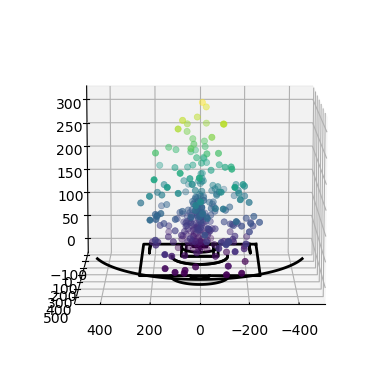

In [150]:
##Let's take a much cooler view of the data: a 3d-plot
##had to use ChatGPT to modify draw_half_court so that it worked in a 3D setting


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.patches import Circle, Rectangle, Arc
import numpy as np

def plot_circle(ax, center, radius, color='black', lw=2):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, linewidth=lw, alpha=0.8)

def plot_rectangle(ax, corner, width, height, color='black', lw=2):
    x = [corner[0], corner[0] + width, corner[0] + width, corner[0], corner[0]]
    y = [corner[1], corner[1], corner[1] + height, corner[1] + height, corner[1]]
    z = [corner[2]] * 5
    ax.plot(x, y, z, color=color, linewidth=lw)

def plot_arc(ax, center, radius, theta1, theta2, color='black', lw=2):
    u = np.linspace(theta1, theta2, 100)
    x = center[0] + radius * np.cos(np.radians(u))
    y = center[1] + radius * np.sin(np.radians(u))
    z = center[2] * np.ones_like(u)
    ax.plot(x, y, z, color=color, linewidth=lw)

def draw_half_court_3d(ax, color='black', lw=2, outer_lines=False):
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    plot_circle(ax, center=(0, 0, 0), radius=7.5, color=color, lw=lw)

    # Create backboard
    plot_rectangle(ax, corner=(-30, -7.5, 0), width=60, height=-1, color=color, lw=lw)

    # The paint
    plot_rectangle(ax, corner=(-80, -47.5, 0), width=160, height=190, color=color, lw=lw)
    plot_rectangle(ax, corner=(-60, -47.5, 0), width=120, height=190, color=color, lw=lw)

    # Create free throw top arc
    plot_arc(ax, center=(0, 142.5, 0), radius=120, theta1=0, theta2=180, color=color, lw=lw)

    # Create free throw bottom arc
    plot_arc(ax, center=(0, 142.5, 0), radius=120, theta1=180, theta2=0, color=color, lw=lw)

    # Restricted Zone
    plot_arc(ax, center=(0, 0, 0), radius=80, theta1=0, theta2=180, color=color, lw=lw)

    # Three-point line
    plot_rectangle(ax, corner=(-220, -47.5, 0), width=0, height=140, color=color, lw=lw)
    plot_rectangle(ax, corner=(220, -47.5, 0), width=0, height=140, color=color, lw=lw)

    # 3pt arc
    plot_arc(ax, center=(0, 0, 0), radius=475, theta1=22, theta2=158, color=color, lw=lw)

    # Center Court
    plot_arc(ax, center=(0, 422.5, 0), radius=120, theta1=180, theta2=0, color=color, lw=lw)
    plot_arc(ax, center=(0, 422.5, 0), radius=40, theta1=180, theta2=0, color=color, lw=lw)

    if outer_lines:
        # Draw the half-court line, baseline, and side out bound lines
        plot_rectangle(ax, corner=(-250, -47.5, 0), width=500, height=470, color=color, lw=lw)

# Example usage
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=10, azim=90)

# Assuming shots_fixed is your DataFrame containing shot data
x = shots_fixed['LOC_X']
y = shots_fixed['LOC_Y']
z = shots_fixed['CLOSEST_DEFENDER_NEXT']

ax.scatter(x,y, z, c=z, cmap='viridis', linewidth=0.5)
draw_half_court_3d(ax,outer_lines=True)

plt.show()
##this is definitely imperfect, and as such is just for demostration purposes